# Improved BERT + LightGBM for Predicting Week of Sale with Calibrated Probabilities

In [70]:
#!pip install transformers torch lightgbm scikit-learn pandas optuna -q


In [71]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [72]:
df = pd.read_csv("Coles_synthetic_8weeks_v3_cleaned.csv")
df['Week_num'] = df['Week'].str.extract(r'Week\s*(\d+)').astype(int)
df = df.sort_values(by=['product_code', 'Week_num'])

# Add lag feature
df['was_on_special_last_week'] = df.groupby('product_code')['IsOnSpecial'].shift(1).fillna(0)

# Find next sale week
def find_next_sale_weeks(group):
    week_nums = group['Week_num'].values
    sale_flags = group['IsOnSpecial'].values
    next_sale_week = []
    for i in range(len(sale_flags)):
        found = False
        for j in range(i + 1, len(sale_flags)):
            if sale_flags[j] == 1:
                next_sale_week.append(week_nums[j])
                found = True
                break
        if not found:
            next_sale_week.append(None)
    group['next_on_sale_week'] = next_sale_week
    return group

df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)
df.dropna(subset=['next_on_sale_week'], inplace=True)
df['next_on_sale_week'] = df['next_on_sale_week'].astype(int)


C:\Users\utkar\AppData\Local\Temp\ipykernel_37452\2864154845.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)
C:\Users\utkar\AppData\Local\Temp\ipykernel_37452\2864154845.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)


In [73]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_bert_embeddings_in_batches(text_list, tokenizer, model, batch_size=64, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device).eval()
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
            outputs = model(**inputs)
            # CLS token
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)


In [74]:
embeddings = get_bert_embeddings_in_batches(df["item_name"].tolist(), tokenizer, model_bert)
pca = PCA(n_components=100)
embeddings_reduced = pca.fit_transform(embeddings)


In [75]:
structured = df[['item_price', 'unit_price', 'DiscountRate', 'PriceCapped', 'Week_num', 'was_on_special_last_week']].values
X = np.hstack((structured, embeddings_reduced))
y = df['next_on_sale_week']


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [77]:
base_model = lgb.LGBMClassifier(objective='multiclass', num_class=9, class_weight='balanced')
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)


c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                num_class=9,
                                                objective='multiclass'),
                       method='isotonic')

In [78]:
y_pred = calibrated_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Macro-average (good for multiclass)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"🔍 Precision (macro): {precision:.4f}")
print(f"📢 Recall (macro): {recall:.4f}")
print(f"🎯 F1 Score (macro): {f1:.4f}")

# Optionally, micro and weighted scores:
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"\n(Micro Average) Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"(Weighted Average) Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")


c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.6984740590030519
              precision    recall  f1-score   support

           1       0.55      0.42      0.48        78
           2       0.57      0.93      0.71      2106
           3       0.62      0.74      0.67      2888
           4       0.62      0.72      0.66      3565
           5       0.66      0.65      0.66      3831
           6       0.71      0.60      0.65      3554
           7       0.82      0.64      0.72      4130
           8       0.94      0.72      0.82      4423

    accuracy                           0.70     24575
   macro avg       0.68      0.68      0.67     24575
weighted avg       0.72      0.70      0.70     24575

🔍 Precision (macro): 0.6842
📢 Recall (macro): 0.6786
🎯 F1 Score (macro): 0.6701

(Micro Average) Precision: 0.6985, Recall: 0.6985, F1: 0.6985
(Weighted Average) Precision: 0.7236, Recall: 0.6985, F1: 0.7011


In [79]:
# Turn classification report into DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round and display
report_df = report_df.round(3)
display(report_df)


,precision,recall,f1-score,support
1,0.550,0.423,0.478,78.000
2,0.569,0.934,0.707,2106.000
3,0.618,0.740,0.673,2888.000
4,0.616,0.716,0.662,3565.000
5,0.659,0.652,0.655,3831.000
6,0.706,0.598,0.648,3554.000
7,0.818,0.643,0.720,4130.000
8,0.938,0.723,0.817,4423.000
accuracy,0.698,0.698,0.698,0.698
macro avg,0.684,0.679,0.670,24575.000


<Figure size 1000x600 with 0 Axes>

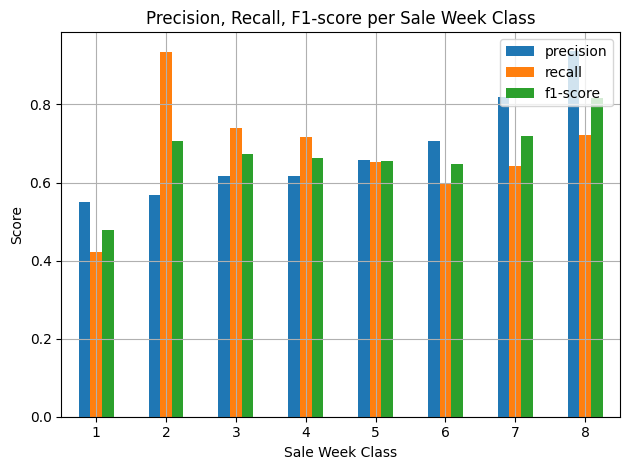

In [80]:
# Extract class-wise precision, recall, f1-score for classes 1-8
class_metrics = report_df.loc[[str(i) for i in range(1, 9)], ['precision', 'recall', 'f1-score']]

# Plotting
plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar')
plt.title('Precision, Recall, F1-score per Sale Week Class')
plt.xlabel('Sale Week Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


In [81]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse} weeks\nMAE: {mae} weeks")


RMSE: 1.1117974595436944 weeks
MAE: 0.5243947100712106 weeks


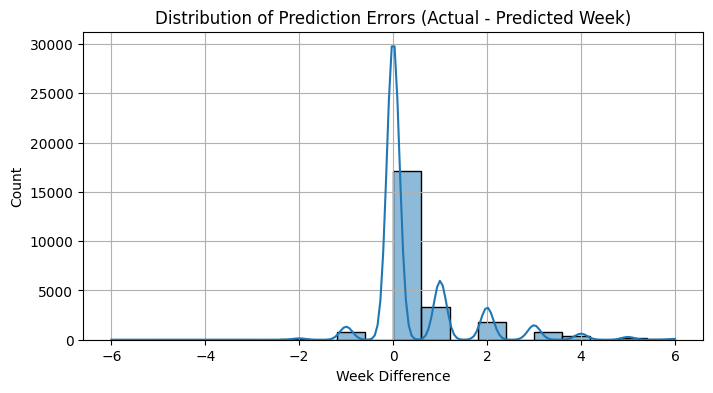

In [82]:
# Compute prediction errors
errors = y_test - y_pred

# Plot histogram of errors
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=20, kde=True)
plt.title("Distribution of Prediction Errors (Actual - Predicted Week)")
plt.xlabel("Week Difference")
plt.ylabel("Count")
plt.grid(True)
plt.show()


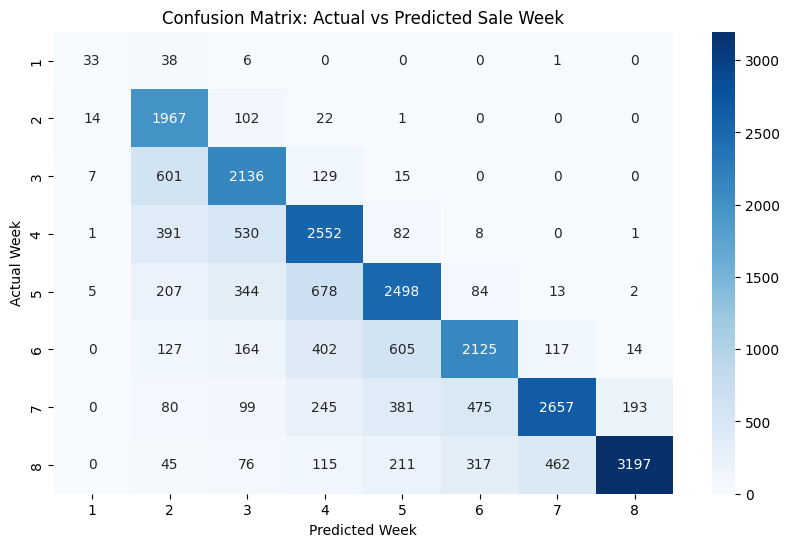

In [83]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(1, 9))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel("Predicted Week")
plt.ylabel("Actual Week")
plt.title("Confusion Matrix: Actual vs Predicted Sale Week")
plt.show()


In [84]:
def predict_next_sale_week(item_name, structured_values, tokenizer, model_bert, pca, model_lgb):
    model_bert.eval()
    inputs = tokenizer([item_name], return_tensors="pt", truncation=True, padding=True, max_length=32)
    with torch.no_grad():
        outputs = model_bert(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embedding_pca = pca.transform(embedding)
    final_input = np.hstack((structured_values, embedding_pca))
    pred_class = model_lgb.predict(final_input)[0]
    prob_dist = model_lgb.predict_proba(final_input)[0]
    return int(pred_class), {week+1: round(prob, 3) for week, prob in enumerate(prob_dist)}


In [85]:
item_name = "Sanitarium Up & Go Liquid Breakfast Choc Ice 3x250ml"
structured_features = np.array([[2.5, 1.25, 0.20, 0, 1, 0]])  # [item_price, unit_price, DiscountRate, PriceCapped, Week_num, was_on_special_last_week]

predicted_week, confidence = predict_next_sale_week(
    item_name=item_name,
    structured_values=structured_features,
    tokenizer=tokenizer,
    model_bert=model_bert,
    pca=pca,
    model_lgb=calibrated_model
)

print(f"🔮 Predicted next sale week: Week {predicted_week}")
print("📊 Probabilities:", confidence)


🔮 Predicted next sale week: Week 2
📊 Probabilities: {1: np.float64(0.002), 2: np.float64(0.738), 3: np.float64(0.136), 4: np.float64(0.056), 5: np.float64(0.061), 6: np.float64(0.007), 7: np.float64(0.0), 8: np.float64(0.0)}


c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: U